In [2]:
import mne
import os
import scipy.io
import listen_italian_functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tqdm import tnrange, tqdm_notebook
import seaborn as sns
import matplotlib as mpl
from scipy import stats
from mne.stats import bonferroni_correction, fdr_correction

sns.set(style="darkgrid")
sns.set(font_scale=1.5)

data_path = os.path.dirname(os.getcwd())

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']

save_path = data_path + '/data/coherence'
info = mne.io.read_raw_fif((save_path+'-info'),preload=True)

remove_first = 0.5 #seconds


Opening raw data file C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info...
This filename (C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
    Range : 40502 ... 1132918 =     40.502 ...  1132.918 secs
Ready.
Reading 0 ... 1092416  =      0.000 ...  1092.416 secs...


# read the partial coherence from mat file

In [ ]:

# let's explore some frequency bands
iter_freqs = [
    ('fr', 1, 3),
    #('fr', 2, 4),
    #('fr', 3, 5),
    ('fr', 4, 6)
    #('fr', 5, 7),
    #('fr', 6, 8),
    #('fr', 7, 9),
    #('fr', 8, 10),
    #('fr', 9, 11),
    #('fr', 10, 12)
]

raw_fname = data_path + '/data/partialCoh/PartialCoherence_'+ str(remove_first)+'.mat'
mat = scipy.io.loadmat(raw_fname)

Feature= mat['data']['Feature'][0]
RemovedFeature= mat['data']['RemovedFeature'][0]
Condition= mat['data']['Condition'][0]
Delay= mat['data']['Delay'][0]
Frequency= mat['data']['Frequency'][0]
Subject= mat['data']['Subject'][0]
partialCoh= mat['data']['Data'][0]

Feature=np.concatenate( Feature[0][0,:], axis=0 )
RemovedFeature=np.concatenate( RemovedFeature[0][0,:], axis=0 )
Condition=np.concatenate( Condition[0][0,:], axis=0 )
Delay=np.concatenate( Delay[0][0,:], axis=0 )
Frequency=np.concatenate( Frequency[0][0,:], axis=0 )
Subject=np.concatenate( Subject[0][0,:], axis=0 )
    

frames = []
for i in range(0,len(Subject)):
    df = pd.DataFrame({'Feature':Feature[i],'RemovedFeature':RemovedFeature[i],'Condition':Condition[i],'Delay':Delay[i],
                 'Freq':Frequency[i],'Subject':Subject[i],'Data':[partialCoh[0][0][i][0]]})
    frames.append(df)
        
data=pd.concat((frames),axis=0)
data['Delay'] = data['Delay'].astype('float64')
data['Delay']=data['Delay'] - 0.5
data['Delay']=data['Delay'].round(decimals=1)

data.set_index(['Feature','RemovedFeature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

a  = data['Data'].apply(lambda x: np.mean(x))
data['partialCoh'] = pd.Series(a, index=data.index)
data.sample(10)

In [ ]:
save_path = data_path + '/data/partialCoh/partialCoh_'+ str(remove_first)+'.pkl'
data.to_pickle(save_path)

# read partial coherence

In [17]:
save_path = data_path + '/data/partialCoh/partialCoh_'+ str(remove_first)+'.pkl'
data=pd.read_pickle(save_path)
a = data.reset_index()
fr = a.Freq.unique()
print(fr)
data.head(10)

['fr 1 - 3Hz' 'fr 4 - 6Hz']


Data  \
Feature RemovedFeature Freq       Condition Delay Subject                                                        
TBCD    TMCD           fr 1 - 3Hz All       -0.5  Alice      [6.95361519195316e-05, 7.263946125567586e-05, ...   
                                                  Andrea     [0.00015811601125974216, 0.0001579859484518926...   
                                                  Daniel     [0.00025494242939923327, 0.0002156332386043629...   
                                                  Elena      [6.61695027785079e-05, 5.955535677046864e-05, ...   
                                                  Elenora    [4.5572832380385684e-05, 4.949831321937673e-05...   
                                                  Elisa      [8.256127124498116e-05, 4.9271832881229645e-05...   
                                                  Federica   [0.00011494050471746668, 8.750853168132827e-05...   
                                                  Francesca  [8.505690759593103e-05, 3.541196561608428e-05,...   
                                                  Giada      [9.579322392418336e-05, 8.506262394343325e-05,...   
                                                  Gianluca1  [7.585704616670158e-05, 5.700860536746253e-05,...   

                                                             partialCoh  
Feature RemovedFeature Freq       Condition Delay Subject                
TBCD    TMCD           fr 1 - 3Hz All       -0.5  Alice        0.000066  
                                                  Andrea       0.000109  
                                                  Daniel       0.000185  
                                                  Elena        0.000098  
                                                  Elenora      0.000038  
                                                  Elisa        0.000092  
                                                  Federica     0.000059  
                                                  Francesca    0.000110  
                                                  Giada        0.000101  
                                                  Gianluca1    0.000084

# seperate data in channels

In [60]:
a = data.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.Data))), columns=info.ch_names)
data = pd.concat([a,df], axis=1)
data.set_index(['Feature','RemovedFeature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)
data.sample(5)

Data  \
Feature       RemovedFeature Freq       Condition Delay Subject                                                       
lipaparature  TTCD           fr 4 - 6Hz Hypo      -0.3  Manu      [0.0001458303693383701, 0.0001376187630488009,...   
TTCD          lipaparature   fr 4 - 6Hz All        0.4  Linda     [5.506877635541297e-05, 2.4027577429796153e-05...   
                             fr 1 - 3Hz All       -0.4  Leonardo  [6.801259676475588e-05, 4.860989312039174e-05,...   
lipProtrusion TBCD           fr 4 - 6Hz Hypo       0.5  Jonluca   [0.00018920036522779564, 0.0001247052969309681...   
lipaparature  envelop        fr 1 - 3Hz Normal    -0.4  Pasquale  [0.00011641355236584725, 0.0001908661868527486...   

                                                                  partialCoh  \
Feature       RemovedFeature Freq       Condition Delay Subject                
lipaparature  TTCD           fr 4 - 6Hz Hypo      -0.3  Manu        0.000177   
TTCD          lipaparature   fr 4 - 6Hz All        0.4  Linda       0.000050   
                             fr 1 - 3Hz All       -0.4  Leonardo    0.000064   
lipProtrusion TBCD           fr 4 - 6Hz Hypo       0.5  Jonluca     0.000133   
lipaparature  envelop        fr 1 - 3Hz Normal    -0.4  Pasquale    0.000083   

                                                                       Fp1  \
Feature       RemovedFeature Freq       Condition Delay Subject              
lipaparature  TTCD           fr 4 - 6Hz Hypo      -0.3  Manu      0.000146   
TTCD          lipaparature   fr 4 - 6Hz All        0.4  Linda     0.000055   
                             fr 1 - 3Hz All       -0.4  Leonardo  0.000068   
lipProtrusion TBCD           fr 4 - 6Hz Hypo       0.5  Jonluca   0.000189   
lipaparature  envelop        fr 1 - 3Hz Normal    -0.4  Pasquale  0.000116   

                                                                       Fp2  \
Feature       RemovedFeature Freq       Condition Delay Subject              
lipaparature  TTCD           fr 4 - 6Hz Hypo      -0.3  Manu      0.000138   
TTCD          lipaparature   fr 4 - 6Hz All        0.4  Linda     0.000024   
                             fr 1 - 3Hz All       -0.4  Leonardo  0.000049   
lipProtrusion TBCD           fr 4 - 6Hz Hypo       0.5  Jonluca   0.000125   
lipaparature  envelop        fr 1 - 3Hz Normal    -0.4  Pasquale  0.000191   

                                                                        F7  \
Feature       RemovedFeature Freq       Condition Delay Subject              
lipaparature  TTCD           fr 4 - 6Hz Hypo      -0.3  Manu      0.000144   
TTCD          lipaparature   fr 4 - 6Hz All        0.4  Linda     0.000051   
                             fr 1 - 3Hz All       -0.4  Leonardo  0.000065   
lipProtrusion TBCD           fr 4 - 6Hz Hypo       0.5  Jonluca   0.000141   
lipaparature  envelop        fr 1 - 3Hz Normal    -0.4  Pasquale  0.000153   

                                                                        F3  \
Feature       RemovedFeature Freq       Condition Delay Subject              
lipaparature  TTCD           fr 4 - 6Hz Hypo      -0.3  Manu      0.000161   
TTCD          lipaparature   fr 4 - 6Hz All        0.4  Linda     0.000072   
                             fr 1 - 3Hz All       -0.4  Leonardo  0.000090   
lipProtrusion TBCD           fr 4 - 6Hz Hypo       0.5  Jonluca   0.000166   
lipaparature  envelop        fr 1 - 3Hz Normal    -0.4  Pasquale  0.000032   

                                                                        Fz  \
Feature       RemovedFeature Freq       Condition Delay Subject              
lipaparature  TTCD           fr 4 - 6Hz Hypo      -0.3  Manu      0.000174   
TTCD          lipaparature   fr 4 - 6Hz All        0.4  Linda     0.000088   
                             fr 1 - 3Hz All       -0.4  Leonardo  0.000076   
lipProtrusion TBCD           fr 4 - 6Hz Hypo       0.5  Jonluca   0.000187   
lipaparature  envelop        fr 1 - 3Hz Normal    -0.4  Pasq

In [ ]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']
freq_band = ['fr 1 - 3Hz', 'fr 4 - 6Hz']

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['envelop','lipaparature']

Removedfeatures = ['envelop','lipaparature']


condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10

column_name = 'FC5'

a = data.loc[features,Removedfeatures,freq_band,condition,delay,subject_name][column_name]
a = pd.DataFrame(a.reset_index())

g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6)
b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", value=column_name,color="deep").add_legend()
b = b.set_xlabels('Delay')
b = b.set_ylabels('Partial Coherence ('+column_name+')')

# topo plot (should be done on two features and 1 freq at a time)¶

In [ ]:
def get_coherence_value1(data,Feature,Removedfeatures,Freq,condition,Delay,subject_name):
    x=[]
    for f in Feature:
        for rf in Removedfeatures:
            for fr in Freq:
                for c in condition:
                    for d in Delay:
                        a  = data.loc[f,rf,fr,c,d,subject_name].as_matrix().mean(axis=0)
                        #if(!np.isnan(a).any())
                        x.append(a[0])
    return x

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].mean()
    mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax)

In [ ]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

freq_band = ['fr 1 - 3Hz']

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['envelop','lipaparature']

Removedfeatures = ['envelop','lipaparature']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10

A = get_coherence_value1(data,features,Removedfeatures,freq_band,condition,delay,subject_name)
A = A[11:-12]
vmax=np.amax(np.concatenate(A, axis=0))
vmin=np.amin(np.concatenate(A, axis=0))

a = data.loc[features,Removedfeatures,freq_band,condition,delay,subject_name]['Data']
a = pd.DataFrame(a.reset_index())


fg = sns.FacetGrid(a, col='Delay', row = 'RemovedFeature',margin_titles=True)
b = fg.map_dataframe(draw_heatmap, 'Data')
b = b.set_xlabels('')
b.fig.subplots_adjust(top=0.9)
b.fig.subplots_adjust(right=0.8)
b.fig.suptitle(freq_band[0])

cbar_ax = b.fig.add_axes([0.82,0.10,0.01,0.75])

#colorbar
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax)

# permutation staticstics on delay time points (should be done on two features and 1 freq at a time)

In [67]:
def run_permutation_test(x,y,numSamples):
    pooled = np.hstack([x,y])
    d0 = x.mean() - y.mean()
    d = np.zeros((numSamples,))
    for k in range(numSamples):
        np.random.shuffle(pooled)
        starZ = pooled[:len(x)]
        starY = pooled[-len(y):]    
        d[k] = starZ.mean() - starY.mean()
        
    p = len(np.where( d >= d0 )[0])
    p = p / float(numSamples)
    
    t,p = stats.ttest_rel(x, y)
    reject_fdr, p = fdr_correction(p, alpha=0.05, method='indep')

    return p.round(decimals=3)

def get_P_value(data,feat_comb,freq_band,condition,delay,numSamples):
    A = []    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[feat_comb[0][0],feat_comb[0][1],fr,c,d,subject_name]['partialCoh']
                group2 = data.loc[feat_comb[1][0],feat_comb[1][1],fr,c,d,subject_name]['partialCoh']
                a = run_permutation_test(group1.get_values(),group2.get_values(),numSamples)
                p = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'p-value':[a]})
                A.append(p)
                
    P = pd.concat((A),axis=0)
    return P


def get_P_value_adaptive(data,feat_comb,freq_band,condition,delay,numSamples):
    A = []    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[feat_comb[0][0],feat_comb[0][1],fr,c,d,subject_name]['Data']
                group2 = data.loc[feat_comb[1][0],feat_comb[1][1],fr,c,d,subject_name]['Data']
                
                aa1=np.where(group1.get_values().mean(axis=0)==group1.get_values().mean(axis=0).max())
                aa2=np.where(group2.get_values().mean(axis=0)==group2.get_values().mean(axis=0).max())
                
                group1 = data.loc[feat_comb[0][0],feat_comb[0][1],fr,c,d,subject_name][info.ch_names[aa1[0][0]]]
                group2 = data.loc[feat_comb[1][0],feat_comb[1][1],fr,c,d,subject_name][info.ch_names[aa2[0][0]]]

                a = run_permutation_test(group1.get_values(),group2.get_values(),numSamples)
                p = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'p-value':[a]})
                A.append(p)
                
    P = pd.concat((A),axis=0)
    return P

In [14]:
find_value = lambda searchList, elem: [[i for i, x in enumerate(searchList) if x == e] for e in elem]
aa = find_value(info.ch_names,column_name)
i = np.asanyarray(aa).flatten()
a  = data['Data'].apply(lambda x: np.mean(x[i]))
data['partialCoh'] = pd.Series(a, index=data.index)

array([], dtype=float64)

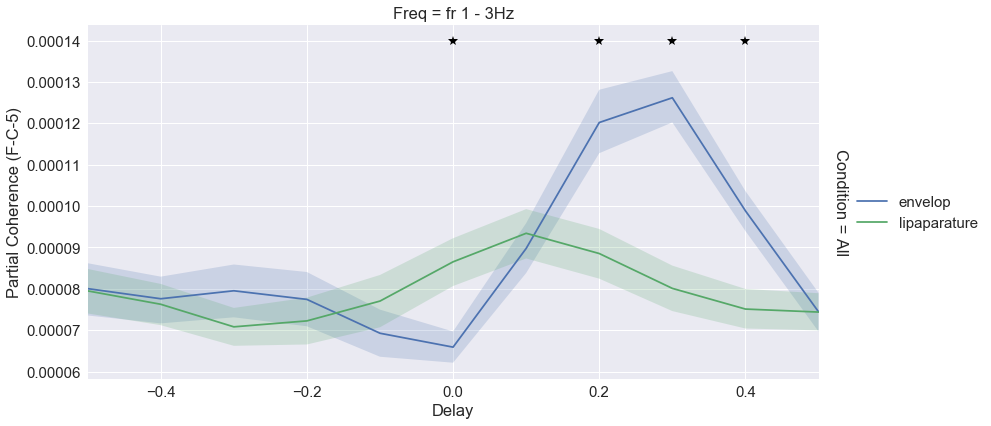

In [69]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = [ 'fr 1 - 3Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

features = ['envelop','lipaparature']
Removedfeatures = ['envelop','lipaparature']

feat_comb = (['envelop','lipaparature'],['lipaparature','envelop'])

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10

column_name = ('FC5')


i = info.ch_names.index(column_name)
a  = data['Data'].apply(lambda x: np.mean(x[i]))
#data['partialCoh'] = pd.Series(a, index=data.index)

a = data.loc[features,Removedfeatures,freq_band,condition,delay,subject_name]['partialCoh']
a = pd.DataFrame(a.reset_index())

# permutation stat
numSamples = 10000
P = get_P_value_adaptive(data,feat_comb,freq_band,condition,delay,numSamples)
x = P[P['p-value'] <= 0.05]['Delay'].get_values()
y = np.repeat(0.00014,len(x))

g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", value='partialCoh',color="deep").add_legend()
b = b.set_xlabels('Delay')
b = b.set_ylabels('Partial Coherence ('+'-'.join(column_name)+')')
# mark the signifiancant point
x = plt.plot(x,y, marker='*', color='k',markersize=10,linestyle='')

# delayed Partial coherence

In [73]:
save_path = data_path + '/data/partialCoh/Delayed_partialCoh-removedFirst-'+ str(remove_first)+'.pkl'
delayed_data=pd.read_pickle(save_path)

delayed_data.set_index(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay',
                        'Freq','Condition','Subject'], inplace=True)
delayed_data.sort_index(inplace=True)

a  = delayed_data['Data'].apply(lambda x: np.mean(x))
delayed_data['partialCoh'] = pd.Series(a, index=delayed_data.index)
delayed_data.sample(10)

Data  \
Feature FeatureDelay RemoveFeature RemoveFeatureDelay Freq       Condition Subject                                                       
envelop 0.2          lipaparature  0.0                fr 4 - 6Hz All       Alice     [1.6637961706972227e-05, 1.7801422967045473e-0...   
                                                      fr 1 - 3Hz All       Sara      [0.0035468640578187284, 0.0017205708558671743,...   
                                                      fr 4 - 6Hz All       Sara      [0.00022836712413640885, 9.190490553951736e-05...   
                                   0.2                fr 1 - 3Hz All       Tommaso   [0.004635639447084365, 0.003084056090215812, 0...   
                                   0.0                fr 1 - 3Hz All       Jonluca   [0.0016251826604842333, 0.00015092362086965651...   
                                                      fr 4 - 6Hz All       Marco     [0.00026610216502247794, 0.0004138980330277346...   
                                   0.2                fr 1 - 3Hz All       Pasquale  [0.0009733381423162335, 0.000419255175819554, ...   
                                                      fr 4 - 6Hz All       Daniel    [0.004604060008752351, 0.0020460702674549047, ...   
                                   0.0                fr 4 - 6Hz All       Martina   [0.007904745856666302, 0.00825241289111113, 0....   
                                   0.2                fr 1 - 3Hz All       Pagani    [0.0013027254942176816, 0.0027596740545692317,...   

                                                                                     partialCoh  
Feature FeatureDelay RemoveFeature RemoveFeatureDelay Freq       Condition Subject               
envelop 0.2          lipaparature  0.0                fr 4 - 6Hz All       Alice       0.002830  
                                                      fr 1 - 3Hz All       Sara        0.002756  
                                                      fr 4 - 6Hz All       Sara        0.000770  
                                   0.2                fr 1 - 3Hz All       Tommaso     0.002617  
                                   0.0                fr 1 - 3Hz All       Jonluca     0.001388  
                                                      fr 4 - 6Hz All       Marco       0.000751  
                                   0.2                fr 1 - 3Hz All       Pasquale    0.000302  
                                                      fr 4 - 6Hz All       Daniel      0.002445  
                                   0.0                fr 4 - 6Hz All       Martina     0.005664  
                                   0.2                fr 1 - 3Hz All       Pagani      0.001090

In [74]:
freq_band = [ 'fr 1 - 3Hz']
condition = ['All']
column_name = ('FC5')




x = delayed_data.loc['envelop',0.2,'lipaparature',0.2,freq_band,condition,subject_name]['partialCoh'].get_values()
y = delayed_data.loc['envelop',0.2,'lipaparature',0,freq_band,condition,subject_name]['partialCoh'].get_values()
t,p = stats.ttest_rel(x, y)
#reject_fdr, p = fdr_correction(p, alpha=0.05, method='indep')

frame = []
for s in range(0,len(subject_name)):
    frame.append(pd.DataFrame({'Name':'envelop-'+str(0.2)+'-lipaparature-'+str(0.2),'Subject':subject_name[s],'Data':[x[s]]}))
    frame.append(pd.DataFrame({'Name':'envelop-'+str(0.2)+'-lipaparature-'+str(0),'Subject':subject_name[s],'Data':[y[s]]}))
    
a = pd.concat((frame),axis=0)

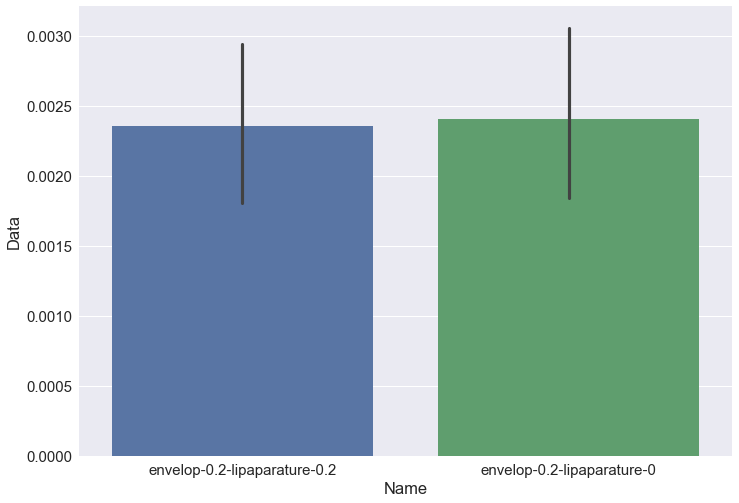

In [76]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
b = sns.barplot(x="Name", y="Data", data=a,ax=ax)
# mark the signifiancant point
#x = P[P['p-value'] <= 0.05]['Delay'].get_values()
#y = np.repeat(0.003,len(x))
#x = plt.plot(x,0.003, marker='*', color='k',markersize=10,linestyle='')

In [75]:
x = data.loc['envelop','lipaparature',freq_band,condition,0.2,subject_name]['partialCoh'].get_values()

0.3568801342105986

In [ ]:
def get_coherence_value_delay(data,name,subject_name,delay,condition): 
    D = []
    D_std = []
    for d in delay:
        A = []
        B=[]
        for c in condition:
            a  = data.loc[name[0],name[1],c,d,subject_name].as_matrix().mean(axis=0)
            A.append(a[0].mean())
            B.append(a[0].std())

        D.append(A)
        D_std.append(B)
        
    D=np.asarray(D)
    D_std=np.asarray(D_std)
    
    frames=[]
    frames1=[]
    for c in range(0,len(condition)):
        frames.append(pd.DataFrame({condition[c]:D[:,c]}))
        frames1.append(pd.DataFrame({condition[c]:D_std[:,c]}))
        
    df=pd.concat((frames),axis=1)
    df.index = delay
    df.index.name = 'Delay'
    
    df_std=pd.concat((frames1),axis=1)
    df_std.index = delay
    df_std.index.name = 'Delay'
    return df,df_std

def get_coherence_value(data,name,subject_name,d,condition):
    x=[]
    for i in condition:
        a  = data.loc[name[0],name[1],name[2],i,d,subject_name].as_matrix().mean(axis=0)
        x.append(a[0])

    return x

def plot_coherence(data,vmax,vmin,axes,name,info): 
    im = mne.viz.plot_topomap(data, info.info, axes=axes, show=False,vmin=vmin,vmax=vmax)
    axes.set(title=name)
    return im

def plot_coherence_preprocess(x,name,condition,delay,info):
    vmax=np.amax(np.concatenate(x, axis=0))
    vmin=np.amin(np.concatenate(x, axis=0))

    fig, axes = plt.subplots(1, len(condition),figsize=(10,4))
    for i in range(0,len(condition)):
        im = plot_coherence(x[i],vmax,vmin,axes[i],condition[i],info)

    fig.suptitle(name[0]+'-Delay-'+ str(delay)+ '-'+name[1])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.04, 0.3])
    fig.colorbar(im[0], cax=cbar_ax)
    fig.show()
    
def plot_coherence_preprocess_delay(x,name,condition,delay,info):
    vmax=np.amax(np.concatenate(x, axis=0))
    vmin=np.amin(np.concatenate(x, axis=0))

    fig, axes = plt.subplots(1, len(delay),figsize=(20,6))
    for i in range(0,len(delay)):
        im = plot_coherence(x[i][0],vmax,vmin,axes[i],delay[i],info)

    fig.suptitle(name[0]+ ' -Removed-'+name[1]+' - '+name[2]+'-'+ str(condition[0]),y=0.7)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.50, 0.01, 0.15])
    fig.colorbar(im[0], cax=cbar_ax)
    fig.show()
    return fig
    

In [ ]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

freq_band = ['fr 1 - 3Hz', 'fr 4 - 6Hz']

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['lipaparature']

Removedfeatures = ['envelop']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10


for f in freq_band:
    A = []
    for feat in features:
        name = (feat,Removedfeatures[0],f)
        for d in delay:
            a = get_coherence_value(data,name,subject_name,d,condition)
            A.append(a)
    a = plot_coherence_preprocess_delay(A,name,condition,delay,info)
    
